<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузите-данные" data-toc-modified-id="Загрузите-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузите данные</a></span></li><li><span><a href="#Исследовательский-анализ-и-предобработку-данных" data-toc-modified-id="Исследовательский-анализ-и-предобработку-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ и предобработку данных</a></span><ul class="toc-item"><li><span><a href="#Для-каждой-таблицы" data-toc-modified-id="Для-каждой-таблицы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Для каждой таблицы</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Общий-анализ-выходных-данных" data-toc-modified-id="Общий-анализ-выходных-данных-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Общий анализ выходных данных</a></span></li><li><span><a href="#Подготовьте-данные-для-обучения" data-toc-modified-id="Подготовьте-данные-для-обучения-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Подготовьте данные для обучения</a></span></li></ul></li><li><span><a href="#Обучите-модель" data-toc-modified-id="Обучите-модель-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучите модель</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Сучайный-лес" data-toc-modified-id="Сучайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Сучайный лес</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Нейросеть" data-toc-modified-id="Нейросеть-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Нейросеть</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Телеком

## Описание проекта

**Заказчик**

Оператор связи «ТелеДом» 

**Задача**

Обучить модель, которая будет предсказывать, разорвёт ли абонент договор. 
Качество модели на тестовых данных на метрике AUC-ROC не менее 0.85

**Данные**

Персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание проекта. Молодец! Это поможет тебе расставлять акценты в выводах.

## Загрузите данные

In [1]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text 
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
import datetime
import math
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [2]:
# Константы
RANDOM_STATE = 24042023

In [3]:
# Конфигурация для подключения к БД
db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# Подключаемся к БД.
engine = create_engine(connection_string) 
conn = engine.connect()

In [6]:
queries = []
tables = ['telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']

In [7]:
# Список запросов.
for table in tables:

    query = '''
    SELECT *
    FROM ''' + table +  '''
    '''
    queries.append(text(query))

In [8]:
# Получаем данные из БД
contract = pd.read_sql_query(queries[0], con=conn)
personal = pd.read_sql_query(queries[1], con=conn)
internet = pd.read_sql_query(queries[2], con=conn)
phone = pd.read_sql_query(queries[3], con=conn)

In [9]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [10]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [11]:
internet

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [12]:
phone

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


In [13]:
# Заменяем именя колонок.
internet.columns = internet.iloc[0]
phone.columns = phone.iloc[0]
internet = internet.drop(internet.index[0])
phone = phone.drop(phone.index[0])

In [14]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
phone.head(5)

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


## Исследовательский анализ и предобработку данных

- Все талицы на месте и содержат данные. 
- Для таблицы 'personal' не было указано что она тоже находится в базе данных 'telecom'. 
- Таблицы 'interne' и 'phone' первой строкой содержали наименования колонок, исправлено.

### Для каждой таблицы

**contract**

In [16]:
# Смотрим пропуски и типы данных.
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [17]:
# Проверяем что все ID уникальные.
len(contract['customerID'].unique())

7043

In [18]:
# Проверяем, что нет аномалий в датах.
contract['BeginDate'].max()

datetime.date(2020, 2, 1)

In [19]:
# Проверяем, что нет аномалий в датах.
contract['BeginDate'].min()

datetime.date(2018, 4, 17)

In [20]:
# Проверяем, что нет аномалий в датах.
contract[~contract['EndDate'].isna()]['EndDate'].max()

datetime.date(2020, 1, 1)

In [21]:
# Проверяем, что нет аномалий в датах.
contract[~contract['EndDate'].isna()]['EndDate'].min()

datetime.date(2019, 10, 1)

In [22]:
# Проверяем значения категориальных переменных.
for column in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(column)
    print(contract[column].value_counts(normalize=True))

Type
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Type, dtype: float64
PaperlessBilling
Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64
PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64


In [23]:
# Функция yes_to_one перводить yes в 1, no - 0. 

def yes_to_one(i):
    if i == 'Yes':
        return 1
    else:
        return 0

In [24]:
# Применяем функцию yes_to_one к колонке PaperlessBilling
contract['PaperlessBilling'] = contract['PaperlessBilling'].apply(yes_to_one)

In [25]:
# Смотрим характеристики числовых переменных.
contract[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


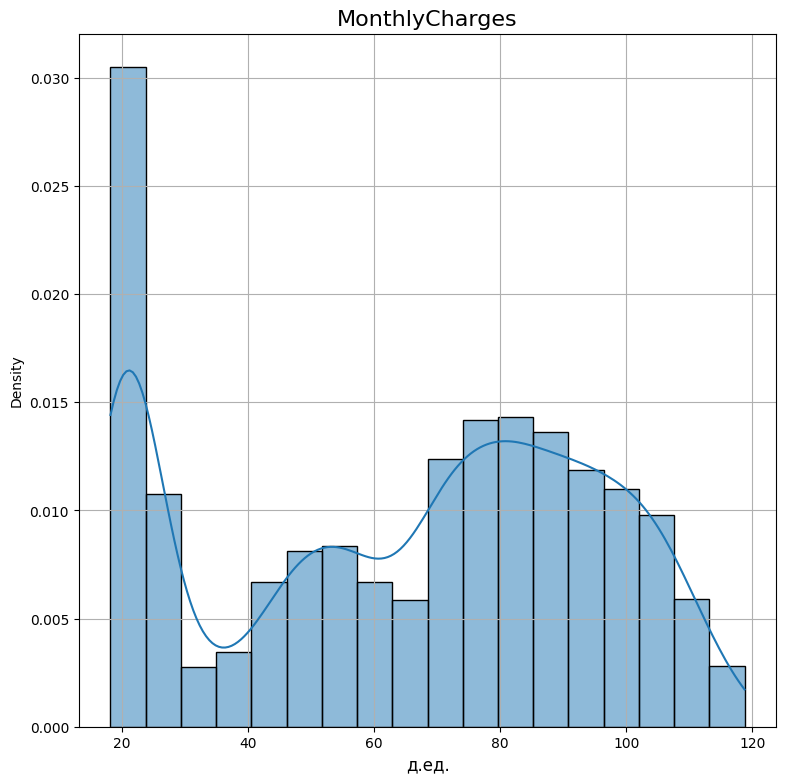

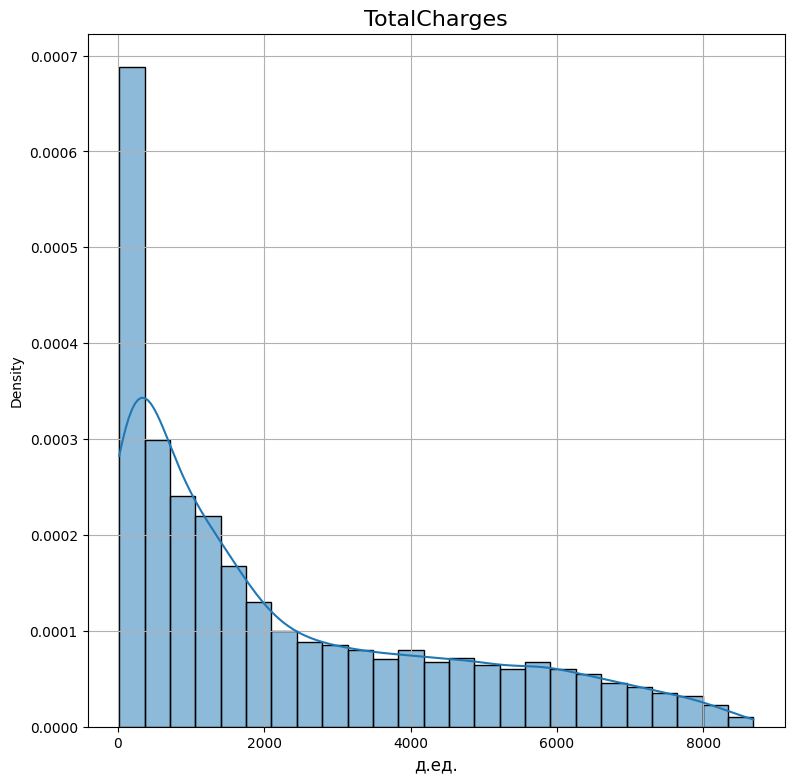

In [26]:
# Визуализируем распределение.
for column in ['MonthlyCharges','TotalCharges']:
    plt.subplots(figsize=(9, 9))
    plt.title(column, fontsize=16)
    sns.histplot(      # гистограммы плотности
            contract[column], 
            kde=True,
            stat="density", 
            linewidth=1)       
    plt.grid(True)
    plt.xlabel('д.ед.',  fontsize=12)
    plt.show()

In [27]:
#  Проверяем nan значения для колонки TotalCharges.
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,1,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,0,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,0,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,0,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,0,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,0,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,1,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,1,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,0,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,0,Mailed check,20.00,NaN


In [28]:
# Заполним nan 0, т.к. эти клиенты еще ничего не заплатили.
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

In [29]:
# Заполним nan 0, т.к. эти клиенты еще не ушли и это будет целевой признак.
contract['EndDate'] = contract['EndDate'].fillna(0)

In [30]:
# Функция contract_duration для вычисления длительности контракта.
def contract_duration(row):
    if  row['EndDate'] == 0:
        return datetime.datetime.strptime('01022020', "%d%m%Y").date() - row['BeginDate']
    else:
        return row['EndDate'] - row['BeginDate']

In [31]:
# Привенним функцию contract_duration переведем дни в числовой формат и переведем наносекунды в дни. 
contract['ContractDuration'] = contract.apply(contract_duration, axis=1).astype('int64') / 24 / 3600 * 1e-9

In [32]:
# Проверяем результат.
contract['ContractDuration'].sample(10)

1952    366.0
3095    297.0
5099    482.0
2813    216.0
6261    306.0
5485    293.0
1316    395.0
3623    342.0
6176    306.0
6194    314.0
Name: ContractDuration, dtype: float64

**personal**

In [33]:
# Смотрим пропуски и типы данных.
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [34]:
# Проверяем что все ID уникальные.
len(personal['customerID'].unique())

7043

In [35]:
# Проверяем значения категориальных переменных.
for column in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    print(column)
    print(personal[column].value_counts(normalize=True))

gender
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
SeniorCitizen
0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64
Partner
No     0.516967
Yes    0.483033
Name: Partner, dtype: float64
Dependents
No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64


In [36]:
# Применяем функцию yes_to_one к колонке Partner и Dependents.
for column in ['Partner', 'Dependents']:
    personal[column] = personal[column].apply(yes_to_one)

**internet**

In [37]:
# Смотрим пропуски и типы данных.
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [38]:
# Проверяем что все ID уникальные.
len(internet['customerID'].unique())

5517

In [39]:
# Проверяем значения категориальных переменных.
for column in ['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    print(column)
    print(internet[column].value_counts(normalize=True))

InternetService
Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64
OnlineSecurity
No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64
OnlineBackup
No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64
DeviceProtection
No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64
TechSupport
No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64
StreamingTV
No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64
StreamingMovies
No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64


In [40]:
# Применяем функцию yes_to_one к категариальным переменным.
for column in ['OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[column] = internet[column].apply(yes_to_one)

**phone**

In [41]:
# Смотрим пропуски и типы данных.
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [42]:
# Проверяем что все ID уникальные.
len(phone['customerID'].unique())

6361

In [43]:
# Проверяем значения категориальных переменных.
phone['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

In [44]:
# Применяем функцию yes_to_one к MultipleLines.
phone['MultipleLines'] = phone['MultipleLines'].apply(yes_to_one)

**Выводы**

1. contract:
- все ID уникальны,
- даты не выходят за рамки обозначенных,
- пропуски в EndDate связаны с не окончанием контракта, заполнены 0,
- пропуски в TotalCharges связаны с новыми контрактам, клиенты просто еще ничего не заплатили, заполнены 0,
- категориальные переменные не имеют аномалий и скрытых дубликатов, нет сильных перекосов и маленьких групп,
- TotalCharges имеет явный тяжелый правый хвост,
- MonthlyCharges можно выделить явные 2 группы те кто платя в районе 20 д.е. и те кто платит от 70 до 100;
2. personal:
- все ID уникальны, по количеству совпадают с contract,
- категориальные переменные не имеют аномалий и скрытых дубликатов, нет сильных перекосов и маленьких групп;
3. internet:
- все ID уникальны, их меньше чем в contract, не все пользуются интернетом,
- категориальные переменные не имеют аномалий и скрытых дубликатов, нет сильных перекосов и маленьких групп;
4. phone:
- все ID уникальны, их меньше чем в contract, не все пользуются телефоном,
- категориальные переменные не имеют аномалий и скрытых дубликатов, нет сильных перекосов и маленьких групп.

### Объединение таблиц

In [45]:
# Объединяем таблицы contract и personal.
df = contract.merge(personal, how='inner', on='customerID')

In [46]:
# Проверяем, что все на месте.
len(df) 

7043

In [47]:
# Присоединяем таблицу internet.
df = df.merge(internet, how='left', on='customerID')

In [48]:
# Проверяем, что все на месте.
len(df)

7043

In [49]:
# Присоединяем таблицу phone.
df = df.merge(phone, how='left', on='customerID')

In [50]:
# Проверяем, что все на месте.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   ContractDuration  7043 non-null   float64
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   int64  
 12  Dependents        7043 non-null   int64  
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   float64
 15  OnlineBackup      5517 non-null   float64
 16  DeviceProtection  5517 non-null   float64


In [51]:
# Заполним пропуки для InternetService, укого нет интернета.
df['InternetService'] = df['InternetService'].fillna('No')

In [52]:
# Создадим новый признак для определения наличия телефона.
df['Phone'] = 1

In [53]:
# Проставим 0 у кого телефона нет.
df.loc[df['MultipleLines'].isna(), 'Phone'] = 0

In [54]:
# Проверим результат.
df.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Phone
6739,9979-RGMZT,2019-02-02,0,One year,1,Mailed check,94.05,633.45,364.0,Female,...,0,Fiber optic,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
1490,7228-OMTPN,2019-01-19,2019-12-01,Month-to-month,1,Electronic check,88.45,370.65,316.0,Male,...,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
73,6323-AYBRX,2019-03-08,2020-01-01,Two year,0,Mailed check,19.35,1099.60,299.0,Male,...,0,No,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
255,8919-FYFQZ,2018-12-13,2019-10-01,Month-to-month,1,Electronic check,30.35,1359.70,292.0,Male,...,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0
352,6599-RCLCJ,2019-03-21,2019-12-01,Month-to-month,1,Electronic check,109.55,5124.55,255.0,Male,...,0,Fiber optic,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5886,7109-MFBYV,2019-01-31,0,Month-to-month,0,Electronic check,45.45,1233.15,366.0,Male,...,0,DSL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4213,2603-HVKCG,2019-05-04,0,Month-to-month,1,Electronic check,101.40,3143.65,273.0,Male,...,0,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1
4664,8800-JOOCF,2019-02-15,0,Month-to-month,1,Electronic check,84.05,966.55,351.0,Female,...,1,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
2151,3351-NGXYI,2019-01-01,0,Month-to-month,1,Electronic check,54.10,889.00,396.0,Female,...,0,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
7023,4807-IZYOZ,2018-12-22,0,Two year,0,Bank transfer (automatic),20.65,1020.75,406.0,Female,...,0,No,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [55]:
# Заполняем пропуски, т.к. ели нет основной услуги нет и дополнительной.
fillna_col = ['OnlineSecurity', 
              'OnlineBackup', 
              'DeviceProtection',
              'TechSupport',
              'StreamingTV', 
              'StreamingMovies',
              'MultipleLines']

df[fillna_col] = df[fillna_col].fillna(0)

In [56]:
# Все пропуски заполнены.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   ContractDuration  7043 non-null   float64
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   int64  
 12  Dependents        7043 non-null   int64  
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   float64
 15  OnlineBackup      7043 non-null   float64
 16  DeviceProtection  7043 non-null   float64


In [57]:
# Создадим новый признак, количество дополнительных услуг.
df['AdditionalServices'] = (df['OnlineSecurity']
+ df['OnlineBackup']
+ df['DeviceProtection']
+ df['TechSupport'] 
+ df['StreamingMovies'] 
+ df['MultipleLines'])

In [58]:
# Выделим целевой признак.
df.loc[df['EndDate'] != 0, 'EndDate'] = 1

In [59]:
# Сделаем более подходящий тип данных int.
for column in ['OnlineSecurity',
               'OnlineBackup',
               'DeviceProtection',
               'TechSupport',
               'StreamingTV',
               'StreamingMovies',
              'MultipleLines',
              'EndDate']:
    df[column] = df[column].astype('int')

In [60]:
# Посмотрим баланс классов.
df['EndDate'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: EndDate, dtype: float64

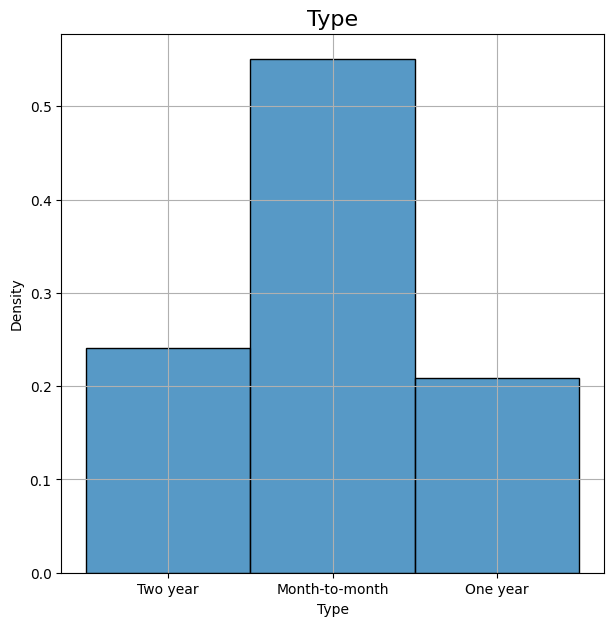

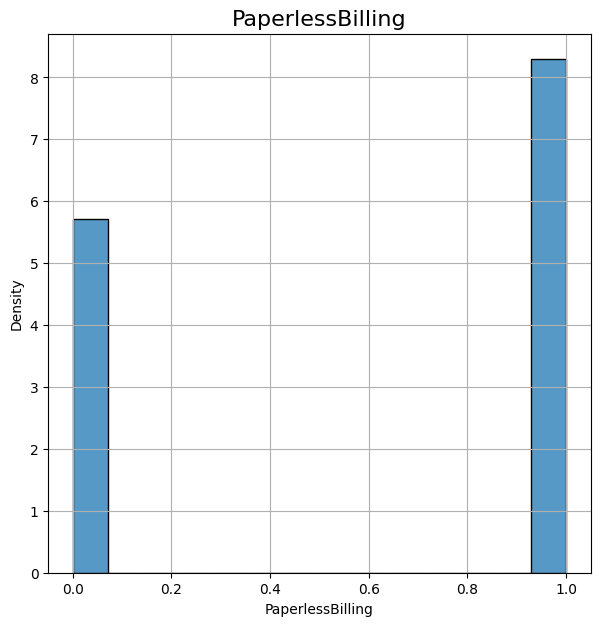

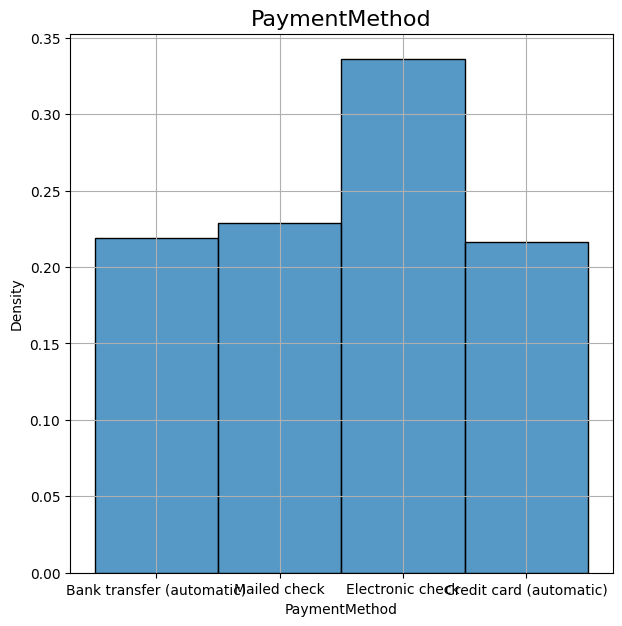

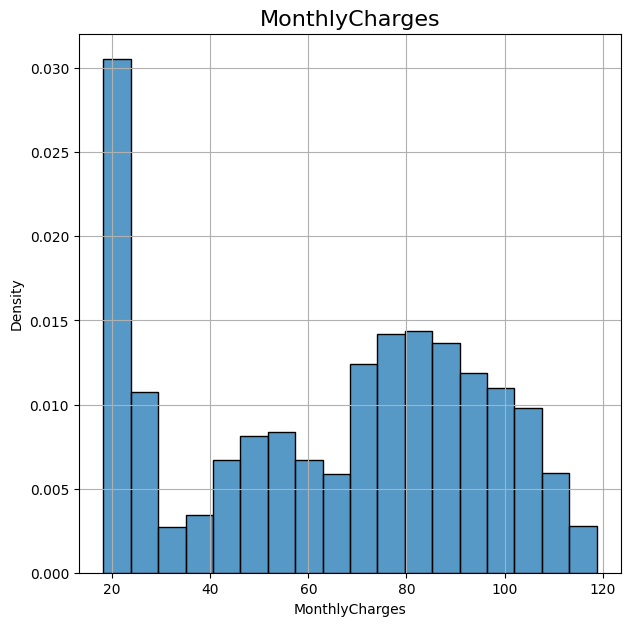

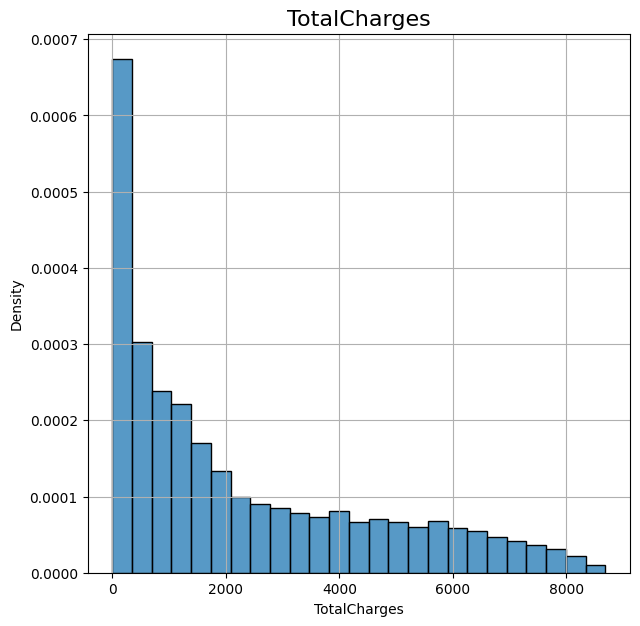

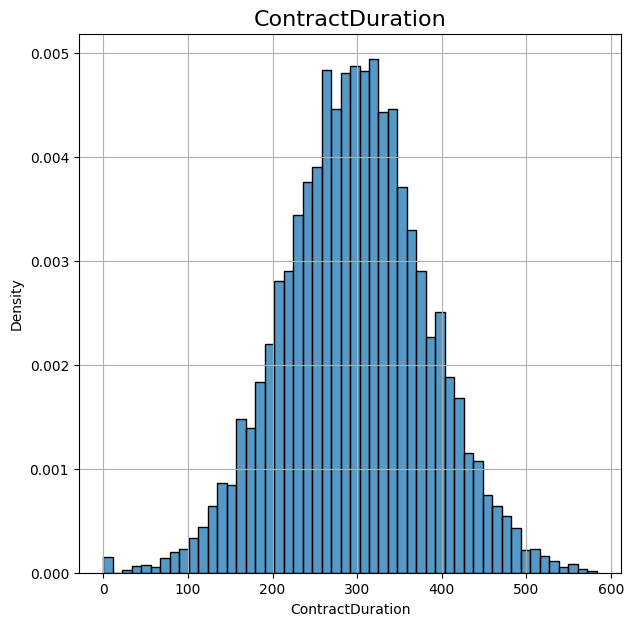

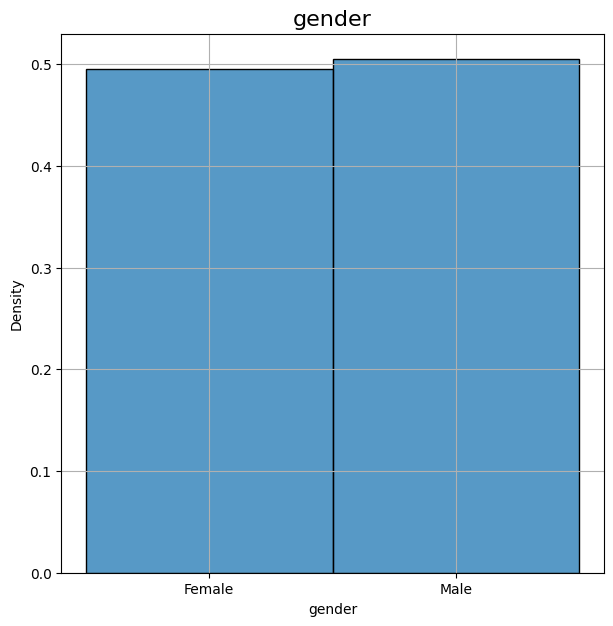

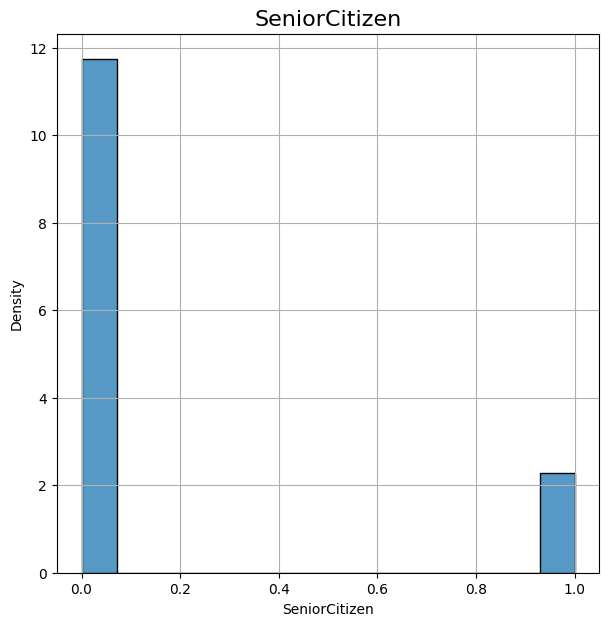

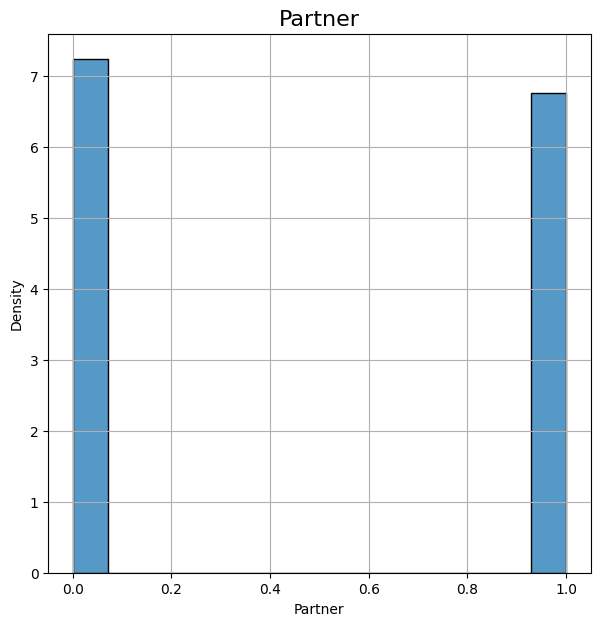

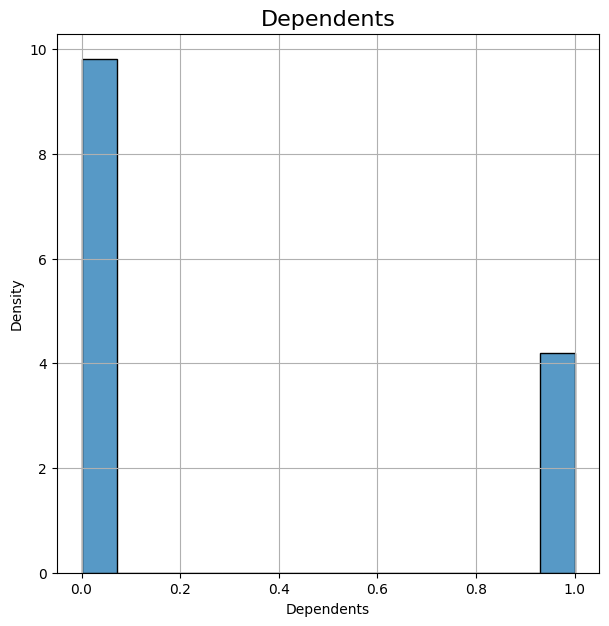

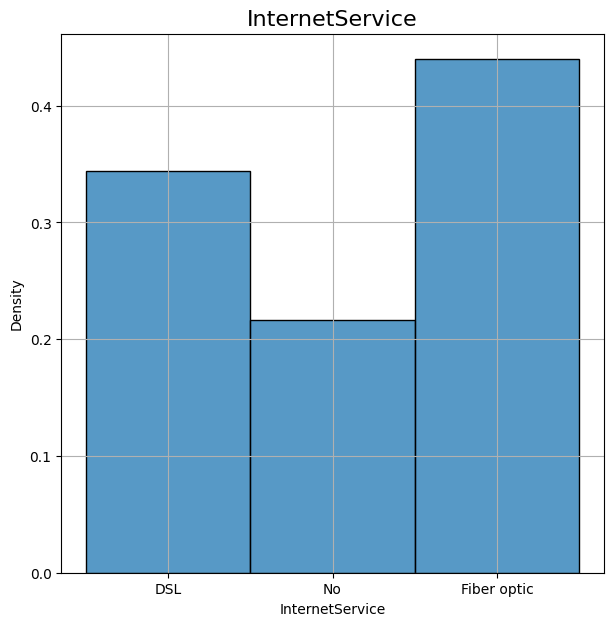

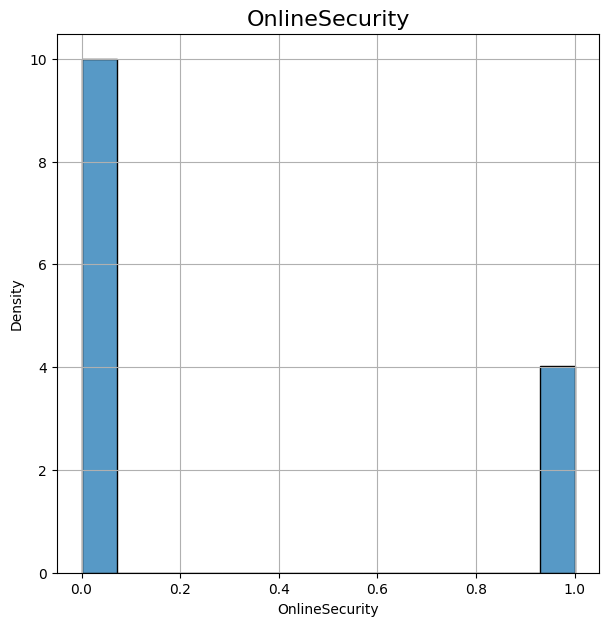

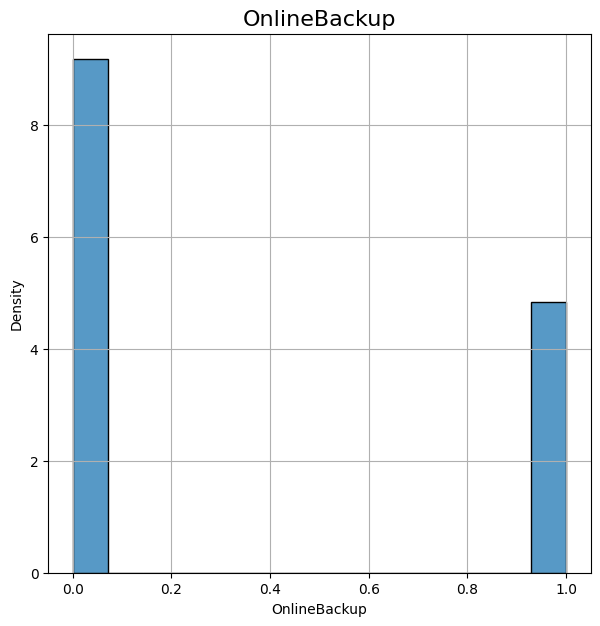

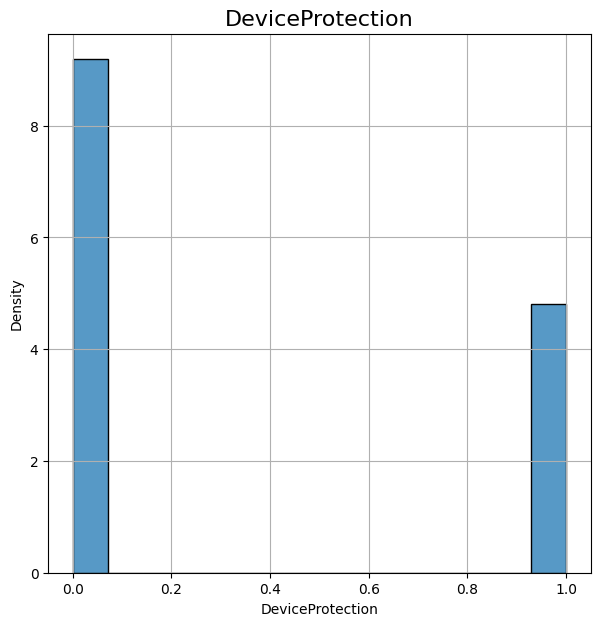

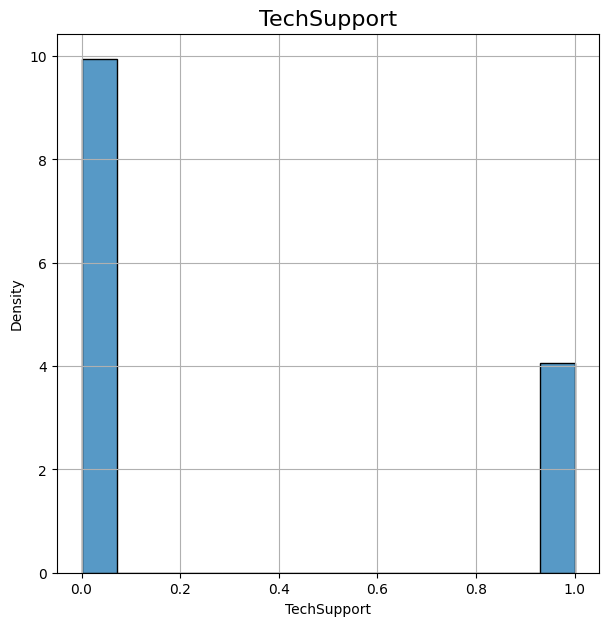

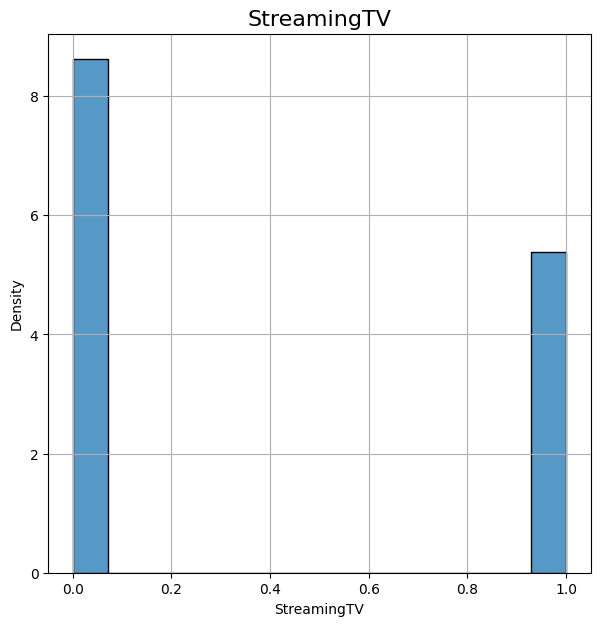

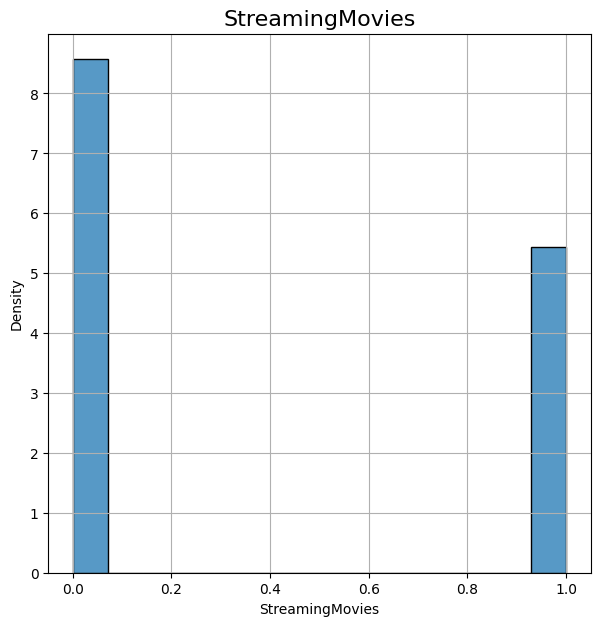

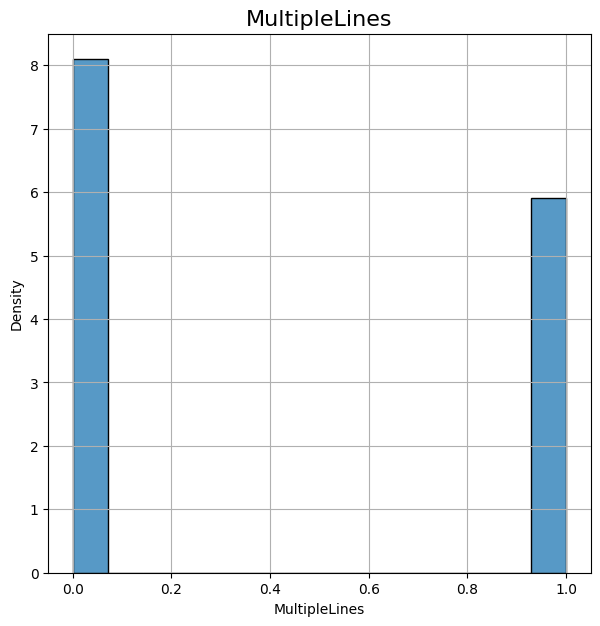

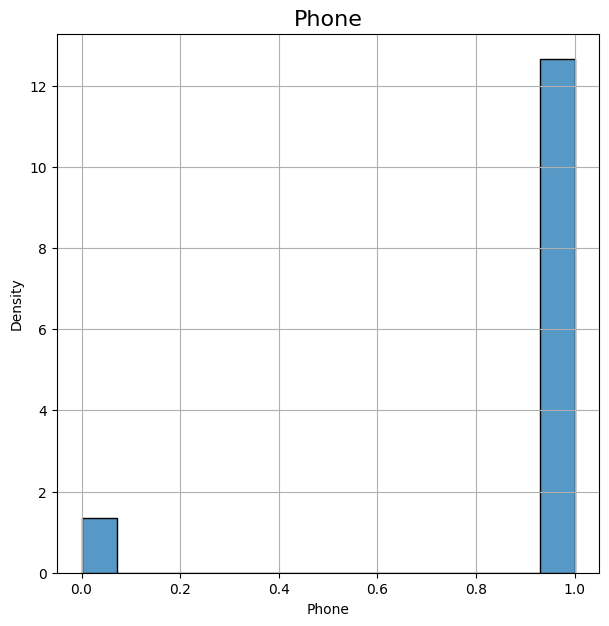

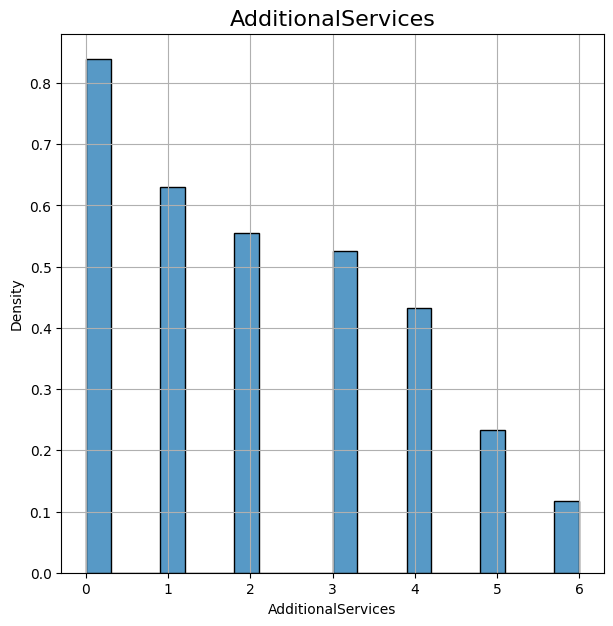

In [61]:
# Визуализируем распределения всех параметров.

for column in ['Type',
               'PaperlessBilling',
               'PaymentMethod',
               'MonthlyCharges',
               'TotalCharges',
               'ContractDuration',
                'gender',
               'SeniorCitizen',
               'Partner',
               'Dependents',
               'InternetService',
               'OnlineSecurity',
               'OnlineBackup',
               'DeviceProtection',
               'TechSupport',
               'StreamingTV',
               'StreamingMovies',
               'MultipleLines',
               'Phone', 
               'AdditionalServices']:
    
    plt.subplots(figsize=(7, 7))
    plt.title(column, fontsize=16)
    sns.histplot(      # гистограммы плотности
            df[column], 
            stat="density", 
            linewidth=1)       
    plt.grid(True)
    plt.show()

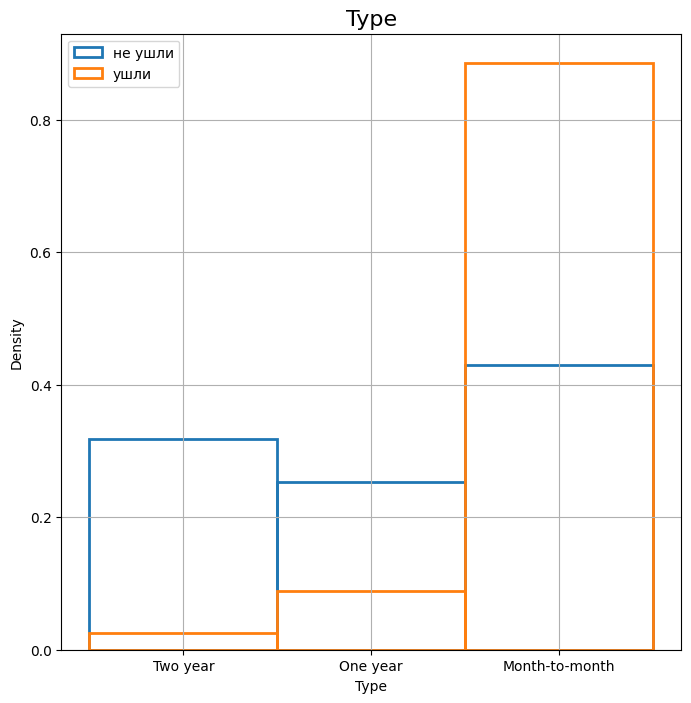

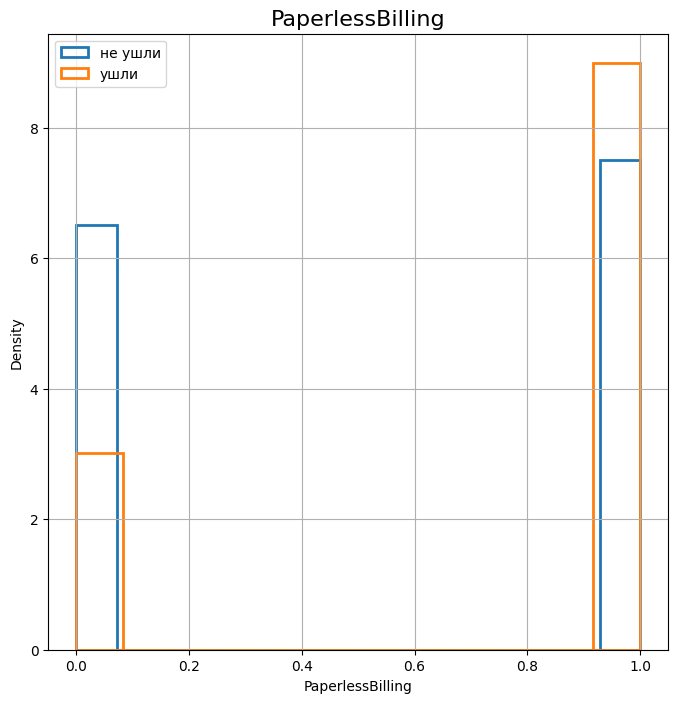

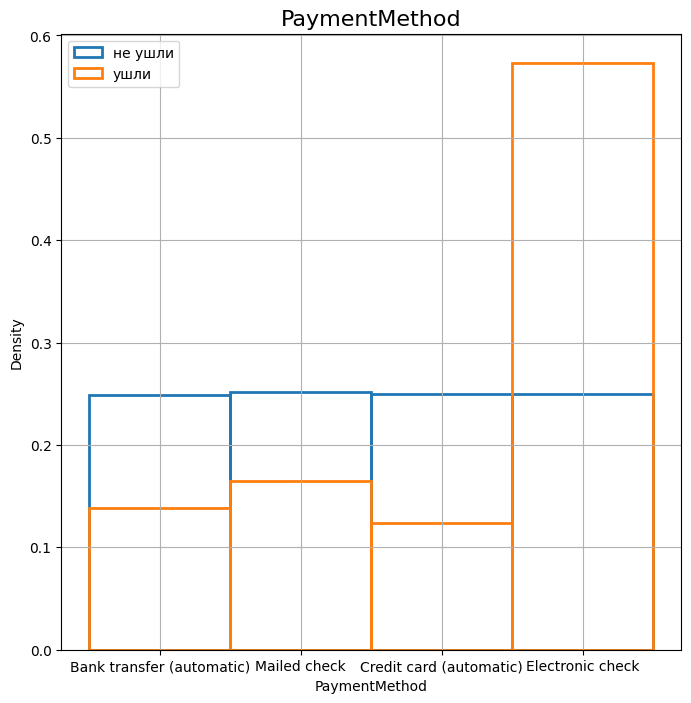

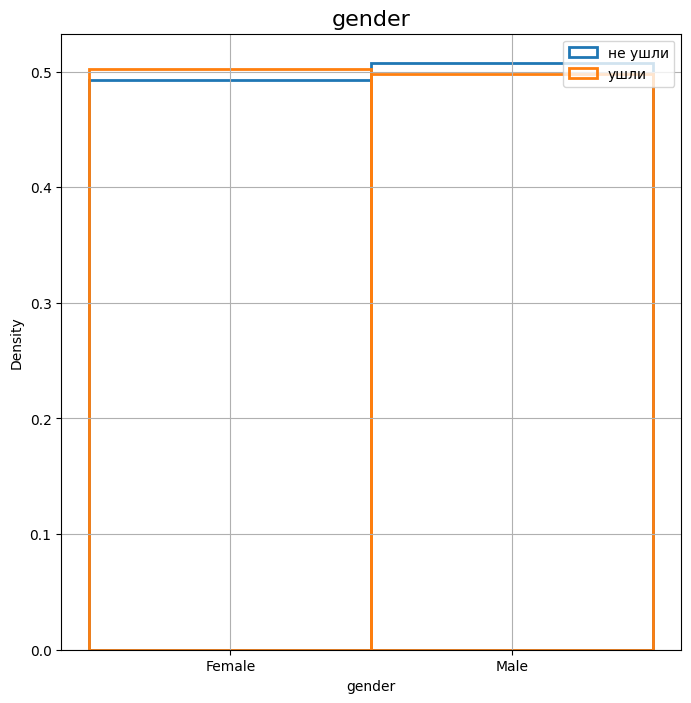

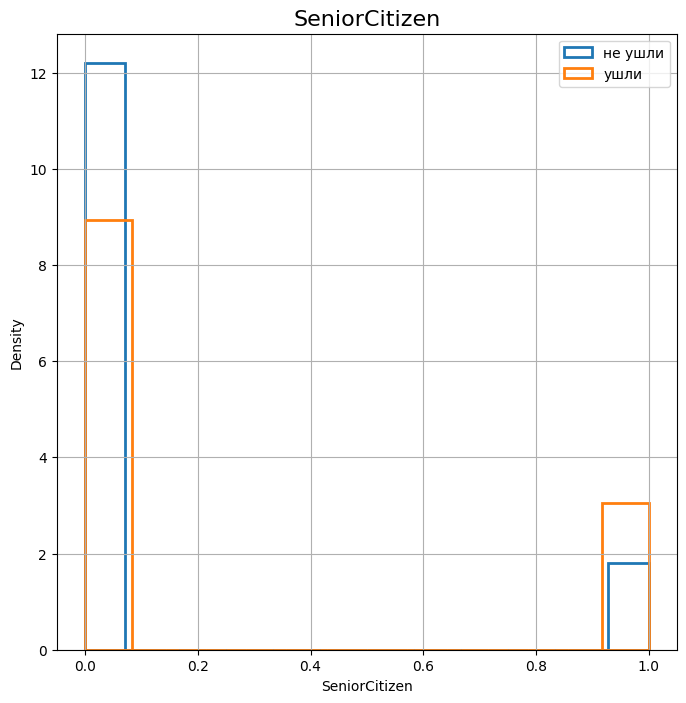

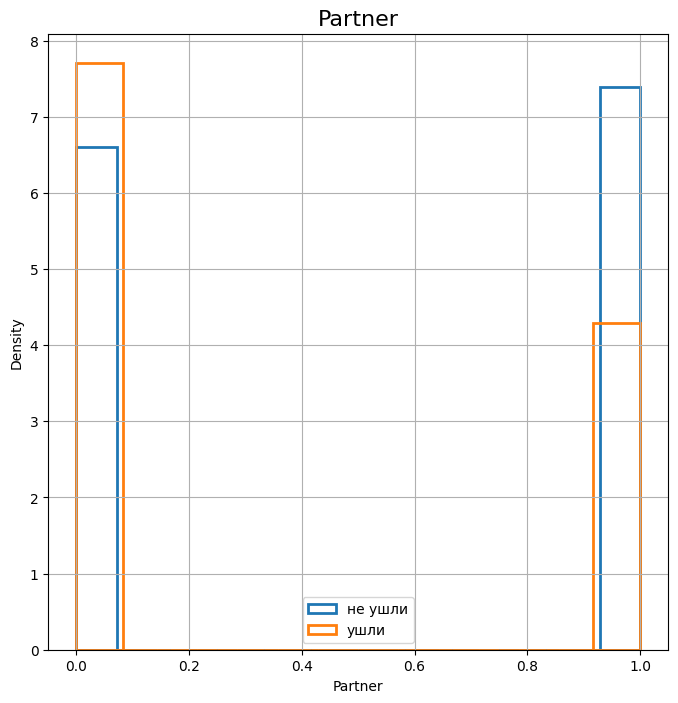

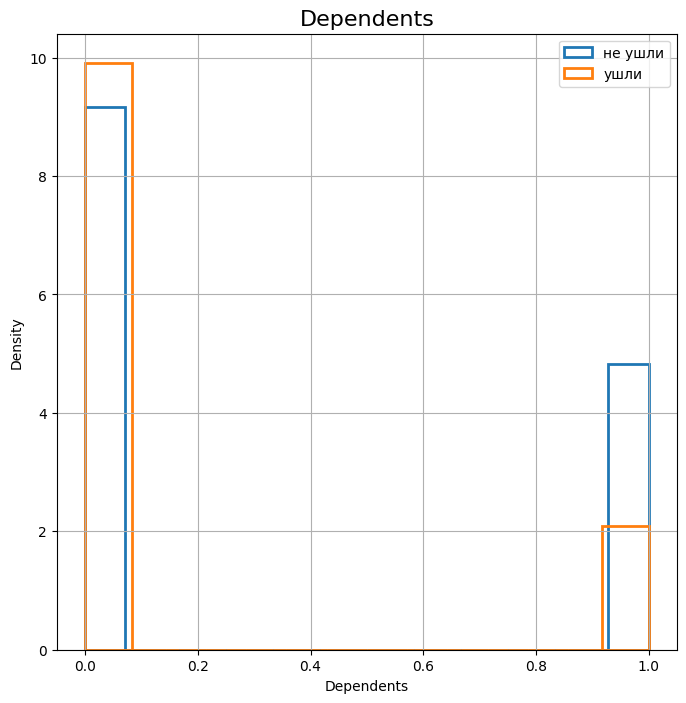

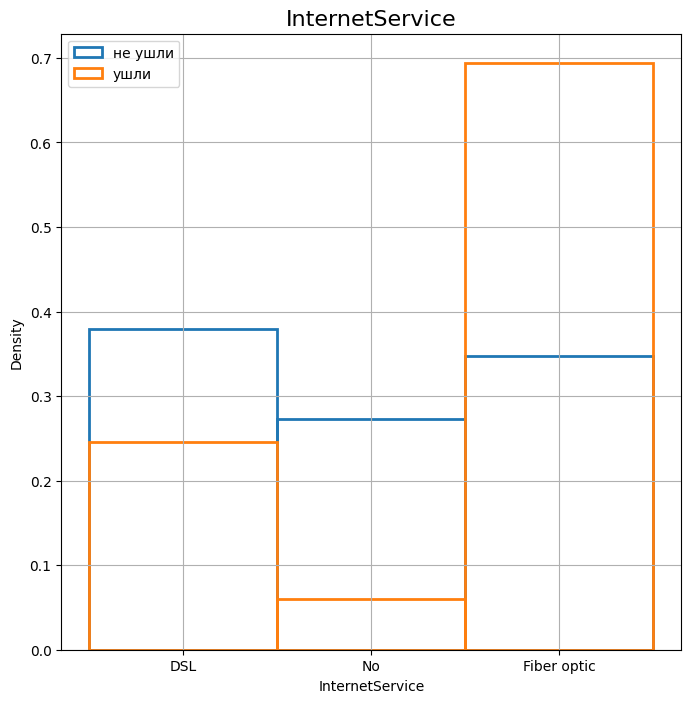

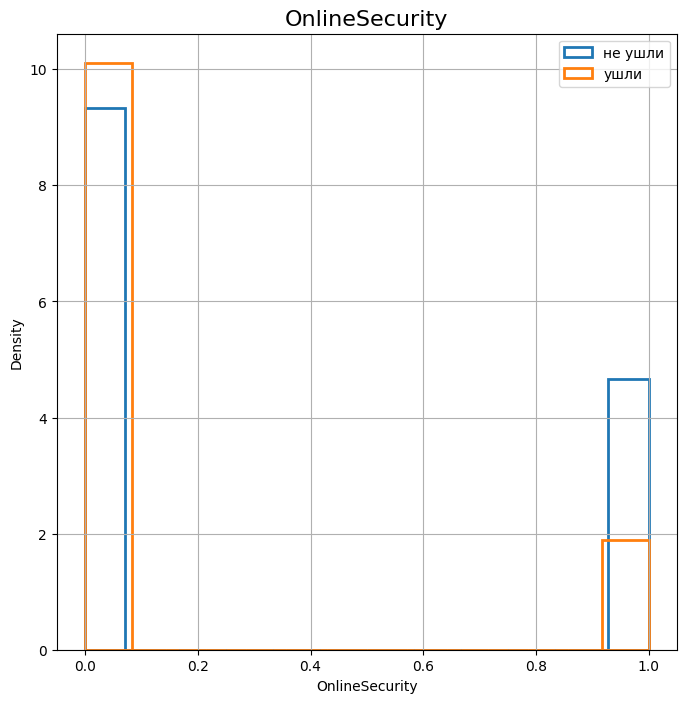

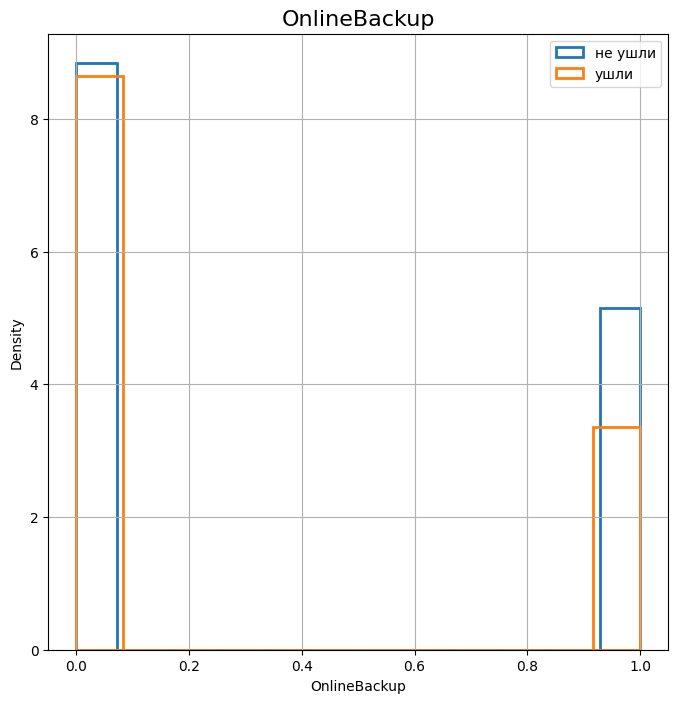

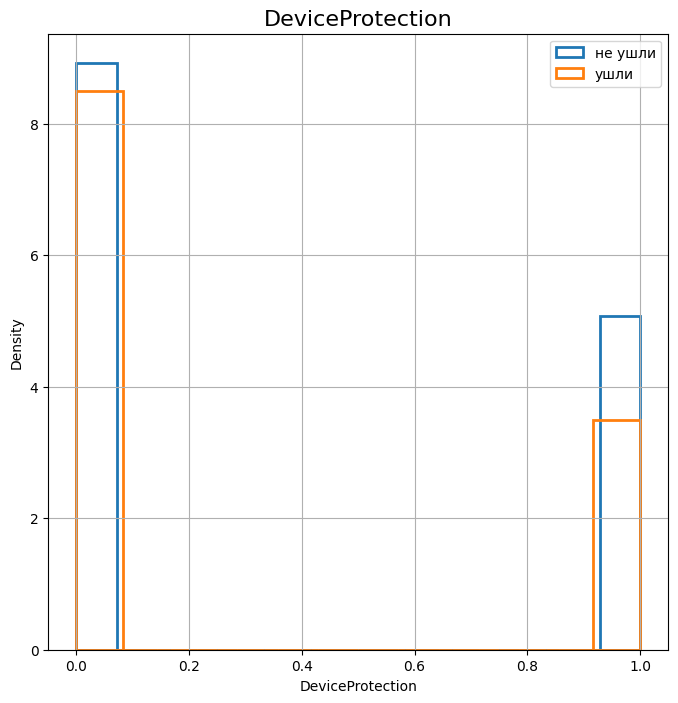

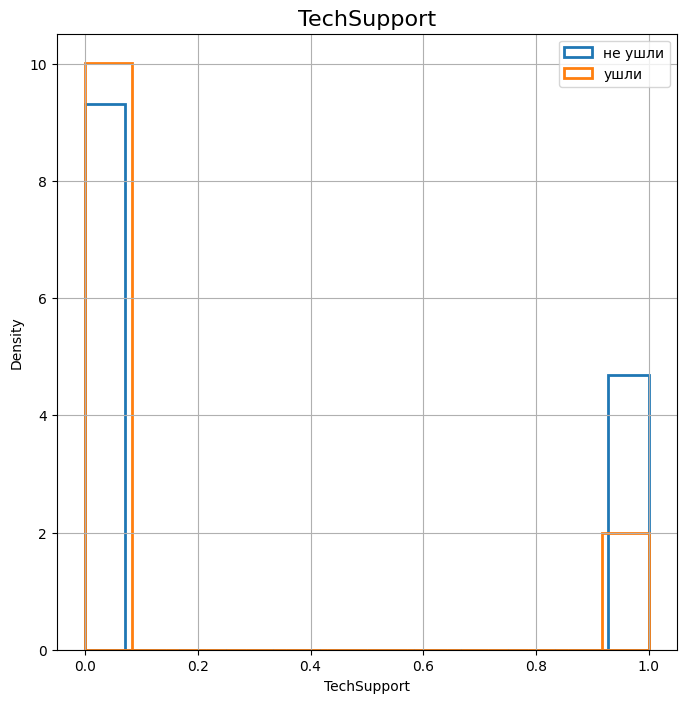

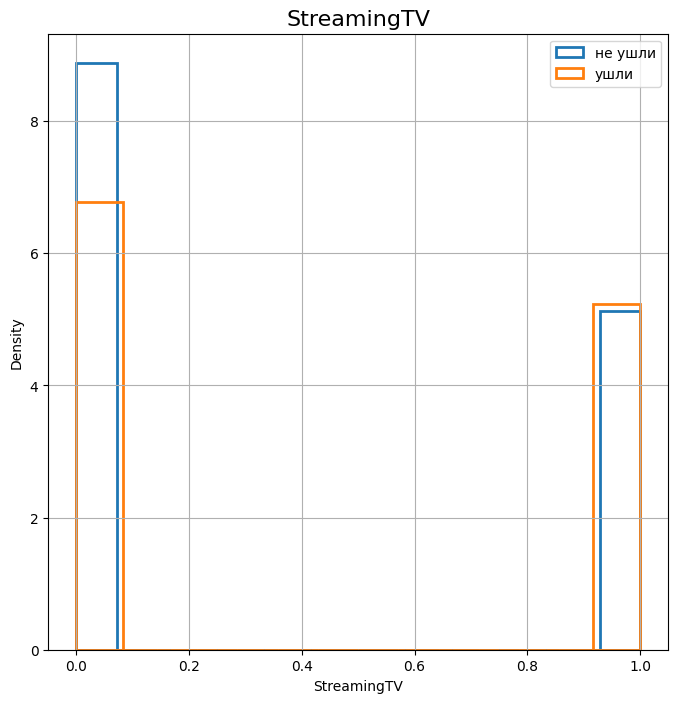

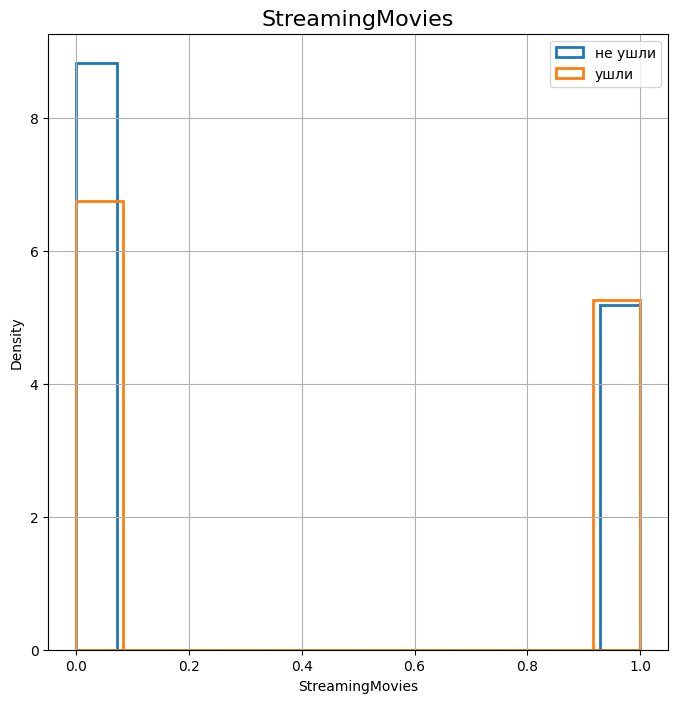

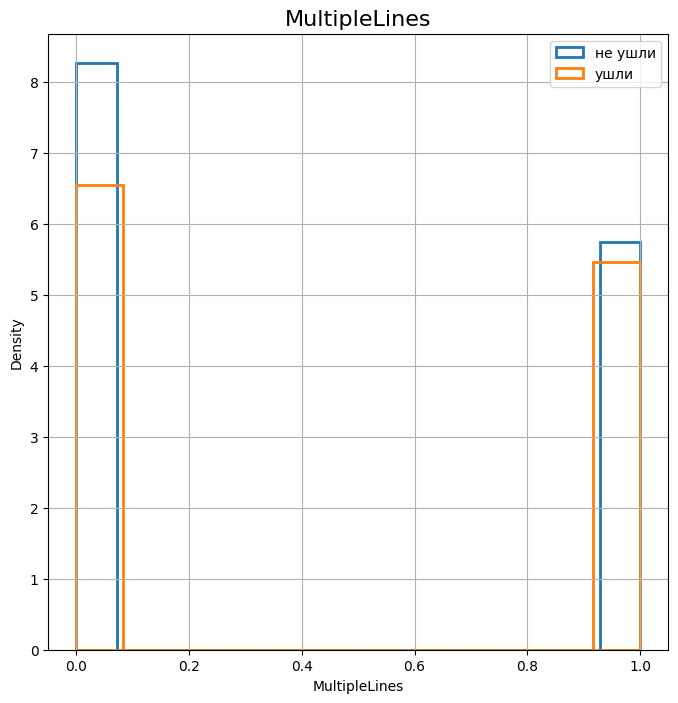

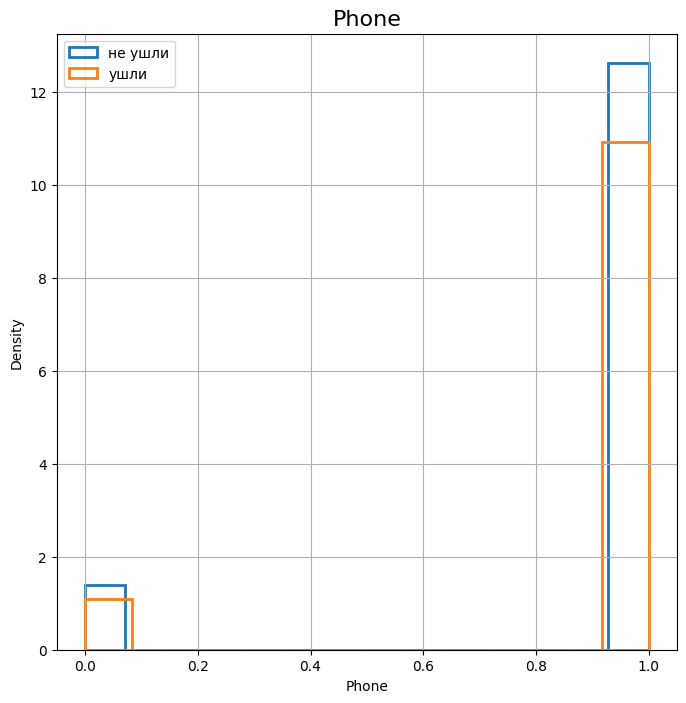

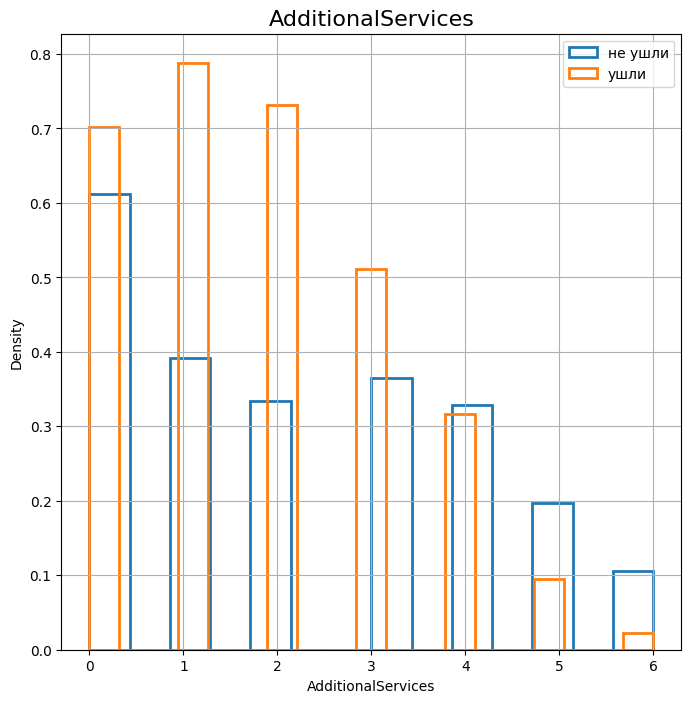

In [62]:
# Сравним распределения для категагиальных переменных.

for column in ['Type', 'PaperlessBilling',
       'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Phone', 'AdditionalServices']:
    
    ip_1 = df[df['EndDate'] == 1]
    ip_0 = df[df['EndDate'] == 0]
    
    plt.subplots(figsize=(8, 8))
    plt.title(column, fontsize=16)
    sns.histplot(      # гистограммы плотности
            ip_0[column], 
            stat="density", 
            linewidth=2,
            element="bars", fill=False)
    sns.histplot(      # гистограммы плотности
            ip_1[column], 
            stat="density", 
            linewidth=2,
            element="bars", fill=False) 
    
    plt.legend(['не ушли', 'ушли']) 
    plt.grid(True)
    plt.show()

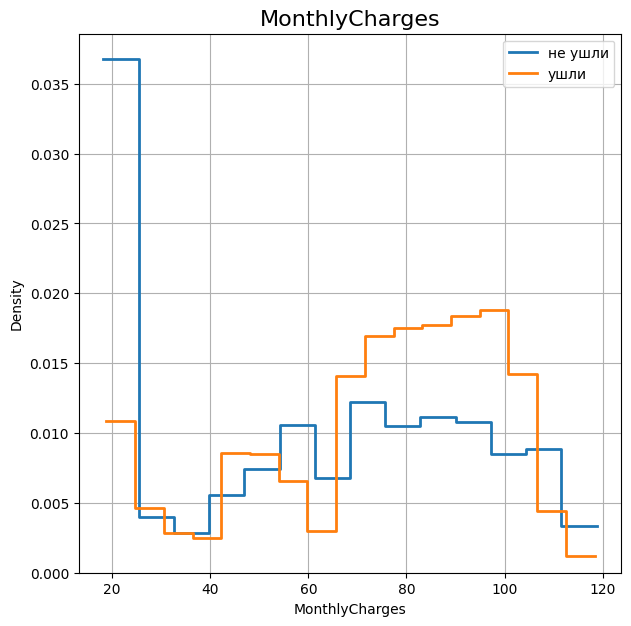

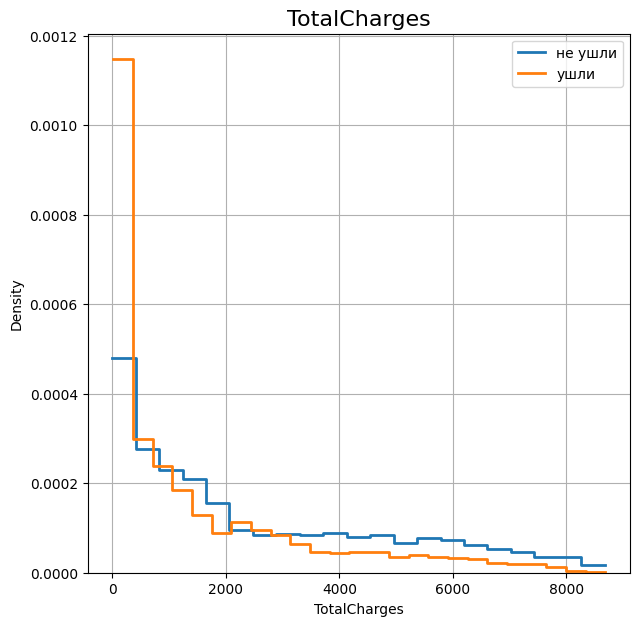

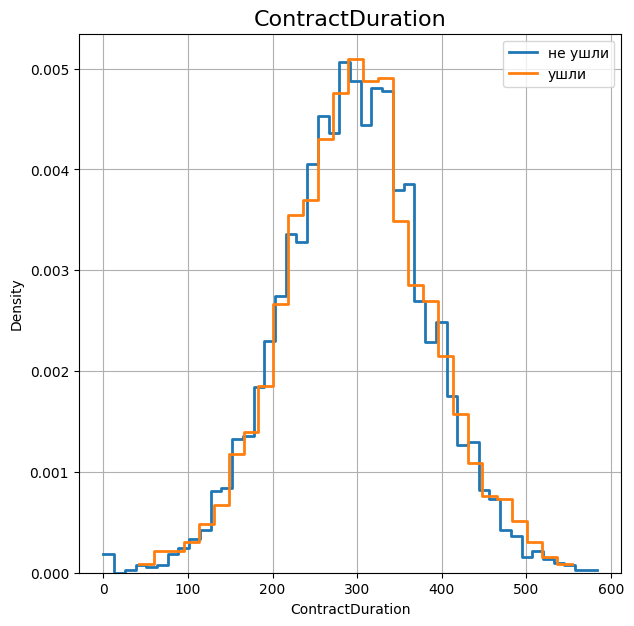

In [63]:
# Сравним распределения для числовых переменных.
for column in ['MonthlyCharges', 'TotalCharges', 'ContractDuration']:
    
    ip_1 = df[df['EndDate'] == 1]
    ip_0 = df[df['EndDate'] == 0]
    
    plt.subplots(figsize=(7, 7))
    plt.title(column, fontsize=16)
    sns.histplot(      # гистограммы плотности
            ip_0[column], 
            stat="density", 
            linewidth=2,
            element="step", fill=False)
    sns.histplot(      # гистограммы плотности
            ip_1[column], 
            stat="density", 
            linewidth=2,
            element="step", fill=False) 
    
    plt.legend(['не ушли', 'ушли']) 
    plt.grid(True)
    plt.show()

In [64]:
phik_overview = df[
    ['Type', 
        'PaperlessBilling',
        'PaymentMethod', 
        'gender', 
        'SeniorCitizen', 
        'Partner', 
        'Dependents',
        'InternetService',
        'OnlineSecurity',
        'OnlineBackup',
        'DeviceProtection',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies',
        'MultipleLines',
        'Phone', 
        'AdditionalServices', 
        'EndDate']
].phik_matrix()

interval columns not set, guessing: ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Phone', 'AdditionalServices', 'EndDate']


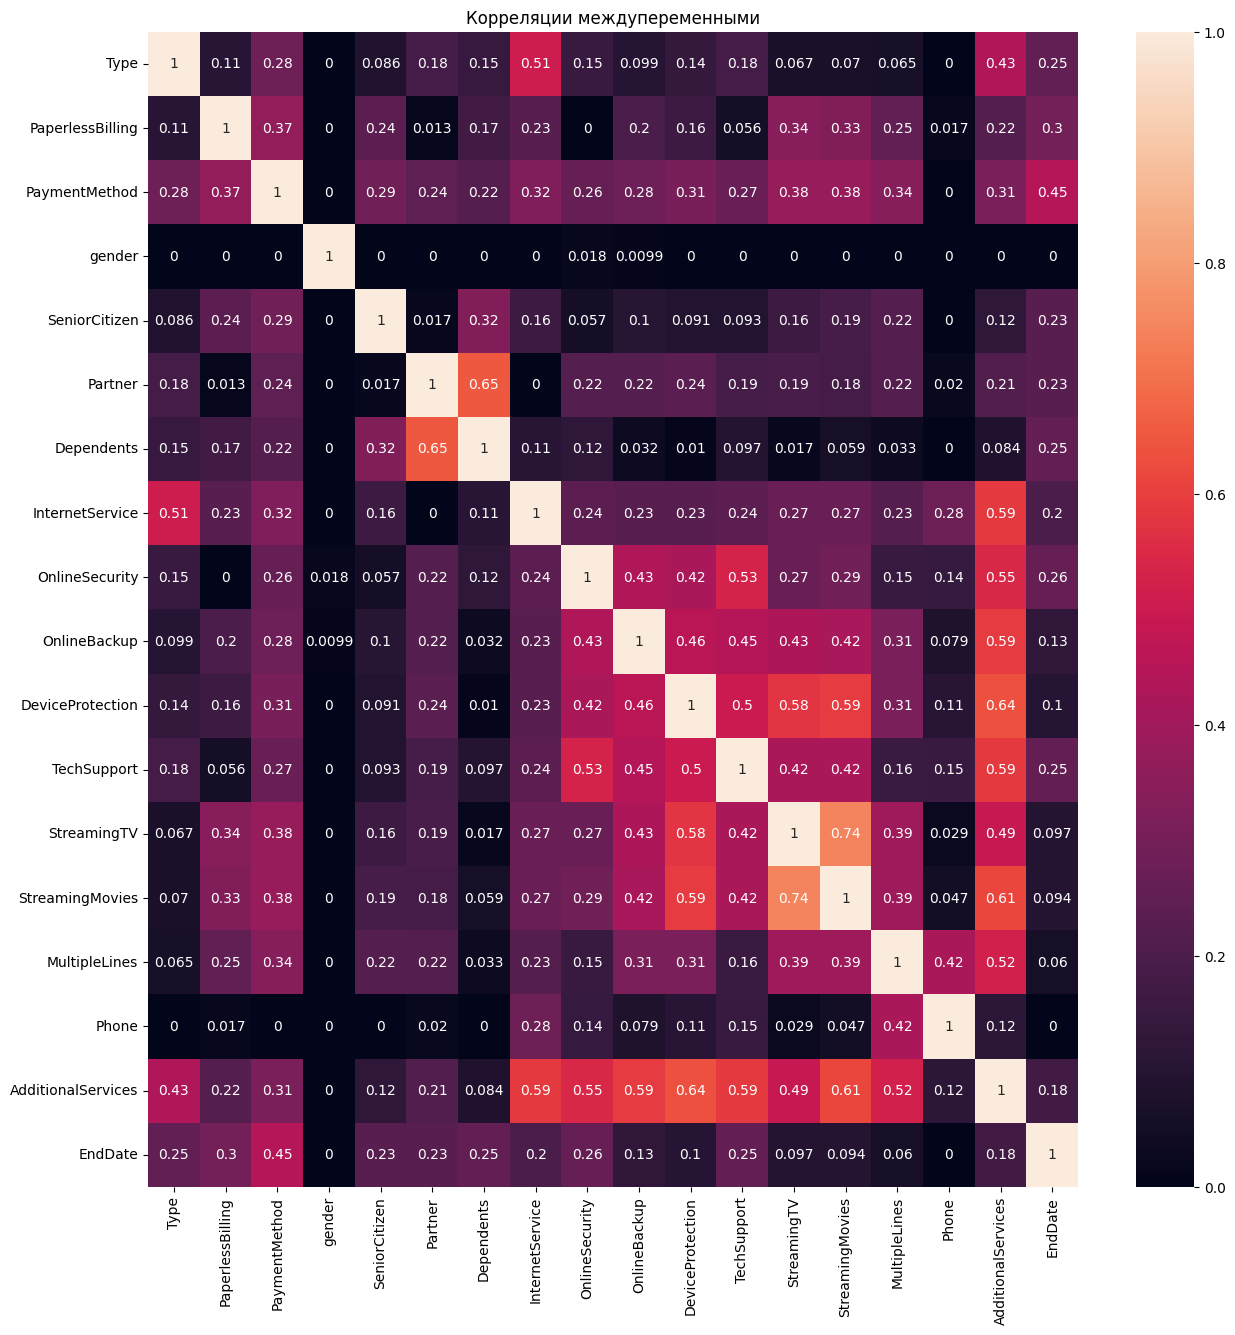

In [65]:
plt.subplots(figsize=(15, 15))
sns.heatmap(phik_overview, annot=True)
plt.title('Корреляции междупеременными')
plt.show()

In [66]:
phik_overview['EndDate'].sort_values(ascending=False)

EndDate               1.000000
PaymentMethod         0.449125
PaperlessBilling      0.295754
OnlineSecurity        0.264580
TechSupport           0.254615
Dependents            0.253936
Type                  0.251639
SeniorCitizen         0.233432
Partner               0.232930
InternetService       0.196202
AdditionalServices    0.175382
OnlineBackup          0.126973
DeviceProtection      0.101516
StreamingTV           0.096865
StreamingMovies       0.093923
MultipleLines         0.059581
gender                0.000000
Phone                 0.000000
Name: EndDate, dtype: float64

### Общий анализ выходных данных

1. Целевая переменная имеет дисбаланс классов 27/73.
2. Введено две дополнительные переменные AdditionalServices и ContractDuration.
3. ContractDuration - имеет нормальное распределение причем как для клиентов, что ушли и для тех, что остались, скорее всего этот параметр сильного улучшения модели не даст.
4. Пол почти никак не влияет, у него равные распределения, дальше его использовать не будем. 
5. Влияние хорошо прослеживается для Type (есть две группы с четкой тенденцией), InternetService и  PaymentMethod.
6. MonthlyCharges имеет две ярко выраженных области, остаются те кто платит мало (20) и уходят те кто платили (70 до 100), думаю связано с тем, что уходя больше людей, которые пользуются fiber optic (InternetService), он похоже дороже чем у конкурентов.
7. Нeatmap по корреляции показал, что целевой признак слабо связан почти со всеми параметрами.
8. Наблюдается корреляция цены за месяц и опций что логично. 

### Подготовьте данные для обучения

In [67]:
# Выделим те перменные что будем использовать.
X = ['Type',
     'PaperlessBilling',
     'PaymentMethod',
     'MonthlyCharges',
     'TotalCharges',
     'ContractDuration',
     'SeniorCitizen',
     'Partner',
     'Dependents',
     'InternetService',
     'OnlineSecurity',
     'OnlineBackup',
     'DeviceProtection',
     'TechSupport',
     'StreamingTV',
     'StreamingMovies',
     'MultipleLines',
     'Phone',
     'AdditionalServices']

In [68]:
# Категориальные пременные.
category_columns = ['Type', 'PaymentMethod', 'InternetService']

In [69]:
# Числовые перменные.
numeric = ['MonthlyCharges',
           'TotalCharges',
          'ContractDuration',
          'AdditionalServices']

In [70]:
# Категориальные бинарные переменные.
other = ['PaperlessBilling',
     'SeniorCitizen',
     'Partner',
     'Dependents',
     'OnlineSecurity',
     'OnlineBackup',
     'DeviceProtection',
     'TechSupport',
     'StreamingTV',
     'StreamingMovies',
     'MultipleLines',
     'Phone']

In [71]:
# Выделим features и target
features = df[X]
target = df['EndDate']

In [72]:
# Разделим на  train и test.
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target, 
    test_size=0.25, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target
)

In [73]:
# Проверим результат.
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5282, 19)
(5282,)
(1761, 19)
(1761,)


## Обучите модель

In [74]:
# Функция для вывода значений Precision, Recall, F1-мера, AUC-ROC, accuracy по обученной модели
# со следующими параметрами:
#    - значения признаков;
#    - значения целевого признака;
#    - обученная модель. 
def print_metrics(features, target, model): 
    
    predicted = model.predict(features)
    probabilities_one = model.predict_proba(features)[:, 1] 

    print(f'Precision: {precision_score(target, predicted):.3f}')
    print(f'Recall: {recall_score(target, predicted):.3f}')
    print(f'F1-мера: {f1_score(target, predicted):.3f}')
    print(f'AUC-ROC: {roc_auc_score(target, probabilities_one): .3f}')
    print(f'Accuracy:{accuracy_score(target, predicted):.3f}')

In [75]:
# Подготовим pipeline для преобразования данных, числовых категориальных и бинарных.
num_pipeline = Pipeline([
  ('scaler', StandardScaler())
])

transform = ColumnTransformer(
    [
     ('num_imputer', num_pipeline, numeric),
     ('ord_encoder', OrdinalEncoder(), category_columns),
     ('ohe_encoder', OneHotEncoder(drop='if_binary'), other)  
     ]
    )

### Дерево решений

In [76]:
# Параметры перебора для дерева решений
parameters = {'model__max_depth': [4, 6, 8],
    'model__max_features': [6, 8, 10, 12]}

In [77]:
# Pipeline для обработки данных и моделирования.
pipeline_dt = Pipeline(
    [
    ('transform', transform),    
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [78]:
dtc_model = GridSearchCV(pipeline_dt, cv=6, n_jobs=-1, param_grid=parameters ,scoring='roc_auc')

In [79]:
%%time
dtc_model.fit(features_train, target_train) # Обучение дерева решений

CPU times: user 544 ms, sys: 20.9 ms, total: 565 ms
Wall time: 3.34 s


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('num_imputer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'ContractDuration',
                                                                          'AdditionalServices']),
                                                                        ('ord_encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Type',
                                                                          'PaymentMethod',
                                                                          'InternetService']),
                                                                        ('ohe_encoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['PaperlessBilling',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'MultipleLines',
                                                                          'Phone'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=24042023))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [4, 6, 8],
                         'model__max_features': [6, 8, 10, 12]},
             scoring='roc_auc')

In [80]:
# Лучшие параметры.
dtc_model.best_params_

{'model__max_depth': 6, 'model__max_features': 12}

In [81]:
# Среднее значение roc_auc по всем кросс-валидациям.
dtc_model.best_score_

0.8181922974908536

### Сучайный лес

In [82]:
# Параметры перебора для случайного леса.
parameters = {'model__n_estimators': [800, 1000],
    'model__max_depth': [4, 6, 8],
    'model__max_features': [4, 6,]}

In [83]:
# Pipeline для обработки данных и моделирования.
pipeline_rf = Pipeline(
    [
    ('transform', transform),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

In [84]:
rfc_model = GridSearchCV(pipeline_rf, param_grid=parameters, scoring='roc_auc', cv=6, n_jobs=-1) 

In [85]:
%%time
rfc_model.fit(features_train, target_train) # Обучение случайного леса.

CPU times: user 9.21 s, sys: 278 ms, total: 9.49 s
Wall time: 4min 52s


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('num_imputer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'ContractDuration',
                                                                          'AdditionalServices']),
                                                                        ('ord_encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Type',
                                                                          'PaymentMethod',
                                                                          'InternetService']),
                                                                        ('ohe_encoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['...
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'MultipleLines',
                                                                          'Phone'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=24042023))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [4, 6, 8],
                         'model__max_features': [4, 6],
                         'model__n_estimators': [800, 1000]},
             scoring='roc_auc')

In [86]:
# Лучшие параметры.
rfc_model.best_params_

{'model__max_depth': 6, 'model__max_features': 6, 'model__n_estimators': 1000}

In [87]:
# Среднее значение roc_auc по всем кросс-валидациям.
rfc_model.best_score_

0.8417421848965839

### CatBoostClassifier

In [88]:
# Параметры перебора для CatBoost.
parameters = {'learning_rate': [0.03, 0.05],
             'depth':[4, 5, 6]} 

In [89]:
cbc = CatBoostClassifier(loss_function="Logloss", iterations=300, random_seed=RANDOM_STATE) # Постоянный гиперпараметры модели.

In [90]:
cbc_model = GridSearchCV(cbc, parameters, scoring='roc_auc', cv=6, n_jobs=-1) 

In [91]:
%%time
cbc_model.fit(features_train, target_train, cat_features=category_columns, verbose=50) # Обучение CatBoost.

0:	learn: 0.6775638	total: 66.9ms	remaining: 20s
50:	learn: 0.4330786	total: 798ms	remaining: 3.9s
100:	learn: 0.4097630	total: 1.67s	remaining: 3.28s
150:	learn: 0.4009993	total: 2.19s	remaining: 2.16s
200:	learn: 0.3949821	total: 2.57s	remaining: 1.27s
250:	learn: 0.3901097	total: 2.97s	remaining: 580ms
299:	learn: 0.3849376	total: 3.34s	remaining: 0us
CPU times: user 5.01 s, sys: 502 ms, total: 5.51 s
Wall time: 1min 36s


GridSearchCV(cv=6,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fad30868880>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6], 'learning_rate': [0.03, 0.05]},
             scoring='roc_auc')

In [92]:
# Лучшие параметры.
cbc_model.best_params_

{'depth': 5, 'learning_rate': 0.03}

In [93]:
# Среднее значение roc_auc по всем кросс-валидациям.
cbc_model.best_score_

0.8462174559602628

### Нейросеть

In [94]:
features_test_ohe =  features_test.copy()
features_train_ohe =  features_train.copy()

In [95]:
# Разделим на  train и valid.
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_train_ohe,
    target_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target_train
)

In [96]:
# Проверим результат.
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(target_train_ohe.shape)
print(target_valid_ohe.shape)

(4225, 19)
(1057, 19)
(4225,)
(1057,)


In [98]:
transform_nn = ColumnTransformer(
    [
     ('num_imputer', num_pipeline, numeric),
     ('ohe_encoder', OneHotEncoder(drop='first'), category_columns),
     ('ohe_bin_encoder', OneHotEncoder(drop='if_binary'), other)  
     ]
    )

In [99]:
transform_nn.fit(features_train_ohe)

ColumnTransformer(transformers=[('num_imputer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['MonthlyCharges', 'TotalCharges',
                                  'ContractDuration', 'AdditionalServices']),
                                ('ohe_encoder', OneHotEncoder(drop='first'),
                                 ['Type', 'PaymentMethod', 'InternetService']),
                                ('ohe_bin_encoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['PaperlessBilling', 'SeniorCitizen',
                                  'Partner', 'Dependents', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'MultipleLines',
                                  'Phone'])])

In [100]:
# Переведем в тензоры.
X_train = torch.FloatTensor(transform_nn.transform(features_train_ohe))
X_val = torch.FloatTensor(transform_nn.transform(features_valid_ohe))
X_test = torch.FloatTensor(transform_nn.transform(features_test_ohe))
y_train = torch.FloatTensor(target_train_ohe.values)
y_val = torch.FloatTensor(target_valid_ohe.values)
y_test = torch.FloatTensor(target_test.values)

In [101]:
X_train.shape

torch.Size([4225, 23])

In [102]:
y_train.shape

torch.Size([4225])

In [103]:
# Параметры НС.
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 4
n_out_neurons = 1
learning_rate = 0.0001
num_epochs = 7000

In [104]:
# Создаем класс НС, определяем два метода.
class Baseline(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, # Инициализация
                 n_hidden_neurons_2, n_out_neurons):
        super(Baseline, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
               
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
                
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()
       
        
    def forward(self, x): # Вычисление
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
       
        return x

In [105]:
net = Baseline(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) # Создаем сеть.

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # Определяем оптимизатор.

loss = nn.BCELoss()

In [106]:
# Обучение НС

ar_train = []
ar_val = []
epoch_50 = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        net.eval()
        train_preds = net.forward(X_train)
        val_preds = net.forward(X_val)
        ar_train.append(roc_auc_score(y_train.detach().numpy(), train_preds.detach().numpy()))
        ar_val.append(roc_auc_score(y_val.detach().numpy(), val_preds.detach().numpy()))
        epoch_50.append(epoch)

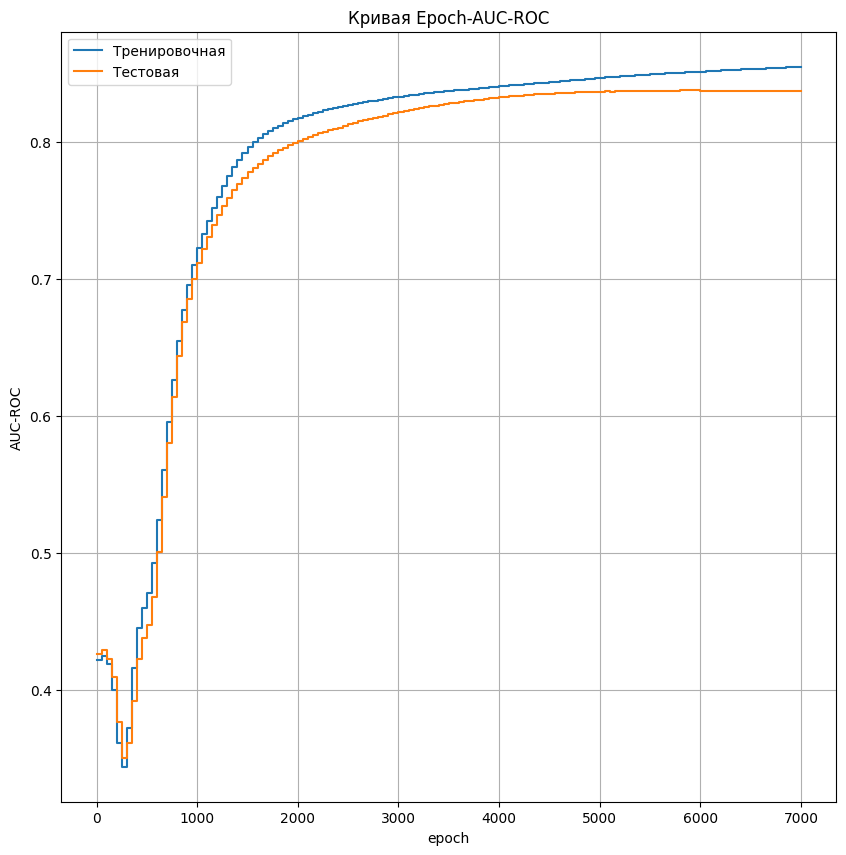

In [107]:
# Строим график изменения AUC-ROC от количества эпох.
plt.figure(figsize=(10, 10))
plt.step(epoch_50, ar_train, where='post')
plt.step(epoch_50, ar_val, where='post')
plt.xlabel('epoch')
plt.ylabel('AUC-ROC')
plt.grid(True)
plt.title('Кривая Epoch-AUC-ROC')
plt.legend(['Тренировочная', 'Тестовая'])
plt.show() 

In [108]:
# Максимальнгое значение roc_auc на валидации.
max(ar_val)

0.8376105220677257

### Вывод

In [109]:
# Вывод по моделированию 
dtс_m = ['DTC', round(dtc_model.best_score_, 3)]
rfс_m = ['RFC', round(rfc_model.best_score_, 3)]
cbс_m = ['CBC', round(cbc_model.best_score_, 3)]
nn_m = ['RFC', round(max(ar_val), 3)]

columns =[
    'model',
    'AUC-ROC'
]
data = []


data.append(dtс_m)
data.append(rfс_m)
data.append(cbс_m)
data.append(nn_m)

pd.DataFrame(data=data, columns=columns)

,model,AUC-ROC
0,DTC,0.818
1,RFC,0.842
2,CBC,0.846
3,RFC,0.838


- Все модели очень близки по значениям.
- Для деревянных использовали предобработку "данных" данных,  в CatBoost возложили ее на внутренние алгоритмы.
- Нейросеть после 7000 переобучается и дальше метрика на малидации идет вниз.
- Т.к. для моделей (кроме нейросети) выводится среднее по кросс-валидации значение получилось ниже 0.85.
- Проверим  CatBoostClassifier на тестовой выборке.

## Тестирование модели

In [110]:
# Метрики лучшей модели на тестовых данных.
print_metrics(features_test, target_test, cbc_model.best_estimator_)

Precision: 0.687
Recall: 0.550
F1-мера: 0.611
AUC-ROC:  0.853
Accuracy:0.814


In [111]:
# Матрица ошибок CatBoost.
predicted = cbc_model.best_estimator_.predict(features_test)
confusion_matrix(target_test, predicted, normalize='all').ravel()
#(tn, fp, fn, tp)

array([0.66837024, 0.06643952, 0.11925043, 0.14593981])

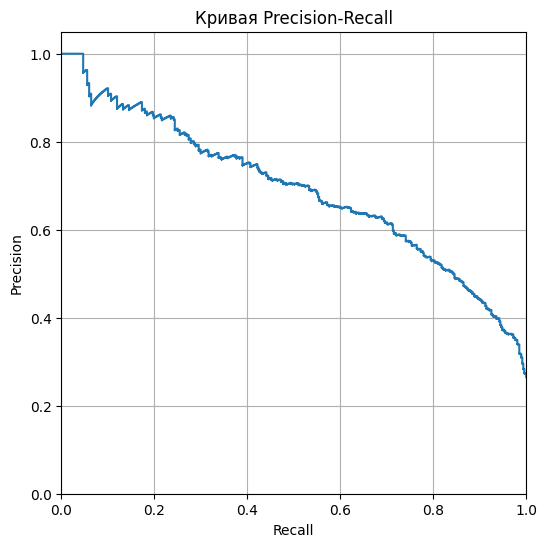

In [112]:
# Построим кривой PR

probabilities_test = cbc_model.best_estimator_.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.grid(True)
plt.show() 

In [113]:
# Важность основных входных признаков.
cbc_model.best_estimator_.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Type,30.014213
1,TotalCharges,18.975891
2,InternetService,13.384147
3,MonthlyCharges,13.344465
4,PaymentMethod,5.269859
5,ContractDuration,3.208532
6,PaperlessBilling,2.166733
7,TechSupport,2.162003
8,AdditionalServices,2.130422
9,StreamingMovies,1.979690


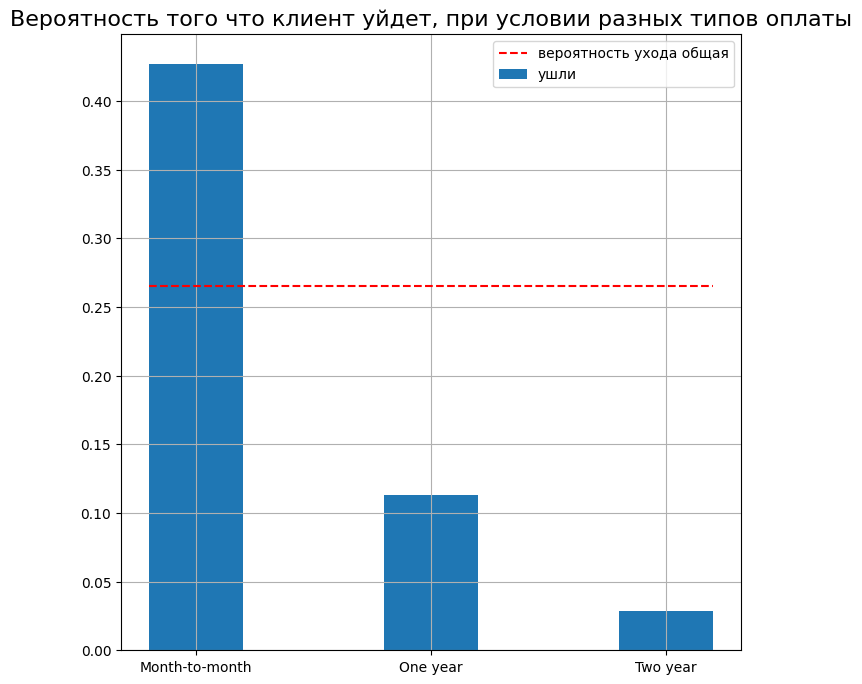

In [114]:
# Условная вероятность по признаку Type.
ip = df.pivot_table( 
                index='Type',
                values='EndDate',
                aggfunc='mean')
plt.subplots(figsize=(8, 8))
plt.title('Вероятность того что клиент уйдет, при условии разных типов оплаты', fontsize=16)
plt.bar(x=ip.index, height = ip['EndDate'], width= 0.4) # вовод графиков 
plt.plot([-0.2, 2.2], [df['EndDate'].mean(), df['EndDate'].mean()], ls='--',  c='r')
plt.legend(['вероятность ухода общая', 'ушли'])      
plt.grid(True)
plt.show()

### Вывод

- Результат достигнут AUC-ROC больше 0.85 на тесте.
- Модель без настроенного порога находит чуть больше половины клиентов которые уйдут, но и лишних флаеров почти не рассылает fp довольно низкое.
- При необходимости в зависимости от бизнес задачи, можно поиграть балансом  Precision и Rcall.
- Как и предполагалось до моделирования Type вносит самый большой вклад, далее TotalCharges,	InternetService, MonthlyCharges, они впринцепе связаны.
-  ContractDuration и AdditionalServices в тоже кое-что внесли и не зря были добавлены, AdditionalServices может заменить все оставшиеся бинарные сервисы кроме TechSupport это довольно важный параметры, клиенты TechSupport с нами остаются дольше.

## Общий вывод

1. Направления по улучшению модели, связаны с выбранной бизнес стратегией (баланс между затратами и результатом), а именно застает порога можно поднять значения TP (Recall) но с ним же возрастет и FP, что может привести к повышению затрат на бонусы, а некоторых случаях и к оттоку клиентов.
2. Рекомендации бизнесу следующие:
- Сосредоточиться на переводе клиентов на схему оплаты раз в 1–2 года (сложно уйти когда все оплачено)  а т.к мат. ожидание по длительности контракта 300 дней, это неплохой способ улучшить этот показатель, скидки бонусы доп опции (в качестве доп опции может быть техподдержка).
- Пересмотреть ценовую политику в предоставлении других услуг fiber optic дешевле у конкурентов, клиенты уходят, и остается только телефон и dsl (не очень актуальные технологии).
- Личные данные клиентов особо не влияют на их приверженность (не стоит сосредотачиваться на их сборе и хранении), всех интересует цена.